# ***Charge deepxde***

In [3]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.3/192.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 8.6 MB/s eta 0:00:00


# ***Problem definition***

In [41]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt


alpha = 10.0
x_g = 3.0
Tf = 4.0
c = 1.0


# calculat domain
geom = dde.geometry.Interval(0, 6)
timedomain = dde.geometry.TimeDomain(0, Tf)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# PDE
def pde(x, y):
    E, H = y[:, 0:1], y[:, 1:2]
    dE_t = dde.grad.jacobian(y, x, i=0, j=1)
    dH_x = dde.grad.jacobian(y, x, i=1, j=0)
    dH_t = dde.grad.jacobian(y, x, i=1, j=1)
    dE_x = dde.grad.jacobian(y, x, i=0, j=0)
    return [dE_t - dH_x, dH_t - dE_x]


# boundary condition
def boundary_lr(x, on_boundary):
    return on_boundary and (np.isclose(x[0], 0) or np.isclose(x[0], 6))

bc_E = dde.icbc.PeriodicBC(
    geomtime,
    component_x = 0,
    derivative_order = 0,
    on_boundary=boundary_lr
)

bc_H = dde.icbc.PeriodicBC(
    geomtime,
    component_x = 1,
    derivative_order = 0,
    on_boundary=boundary_lr
)


# initial condition
def gaussian(x):
    return np.exp(-alpha * (x[:, 0:1] - x_g)**2)

ic_E = dde.icbc.IC(
    geomtime,
    lambda x: gaussian(x),
    lambda _, on_initial: on_initial,
    component=0
)

ic_H = dde.icbc.IC(
    geomtime,
    lambda x: -gaussian(x),
    lambda _, on_initial: on_initial,
    component=1
)


# Neuron Network construction and training

In [42]:
layer_size = [2] + [50] * 6 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_E, bc_H, ic_E, ic_H],
    num_domain=1000,
    num_boundary=180,
    num_initial=180,
)

# Define and train model
model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=20000, display_every=4000)

Compiling model...
Building feed-forward neural network...
'build' took 0.137677 s

'compile' took 1.113635 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [9.73e-02, 7.73e-02, 1.31e+00, 1.31e+00, 4.80e-01, 1.33e-01]    [9.73e-02, 7.73e-02, 1.31e+00, 1.31e+00, 4.80e-01, 1.33e-01]    []  
4000      [2.45e-03, 2.38e-03, 1.48e-04, 1.48e-04, 1.87e-04, 1.86e-04]    [2.45e-03, 2.38e-03, 1.48e-04, 1.48e-04, 1.87e-04, 1.86e-04]    []  
8000      [1.16e-04, 1.72e-04, 5.35e-05, 5.35e-05, 2.49e-05, 5.02e-05]    [1.16e-04, 1.72e-04, 5.35e-05, 5.35e-05, 2.49e-05, 5.02e-05]    []  
12000     [1.70e-05, 1.75e-05, 6.80e-06, 6.80e-06, 1.91e-06, 2.04e-06]    [1.70e-05, 1.75e-05, 6.80e-06, 6.80e-06, 1.91e-06, 2.04e-06]    []  
16000     [9.90e-06, 9.67e-06, 1.06e-06, 1.06e-06, 6.95e-07, 7.21e-07]    [9.90e-06, 9.67e-06, 1.06e-06, 1.06e-06, 6.95e-07, 7.21e-07]    []  
20000

# ***Time Evaluation***

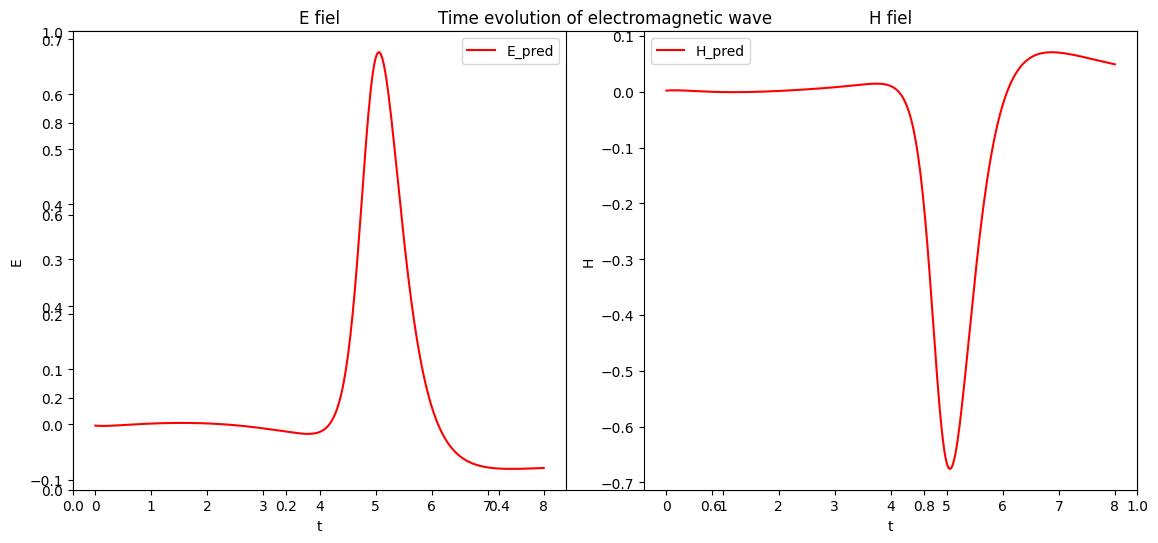

In [32]:
# visualization
x_value = 2  # fixed point
x2 = np.linspace(0, 2 * Tf, 400)
x = np.stack((np.full(x2.shape, x_value), x2), axis=-1)
y = model.predict(x)

E_field = y[:, 0:1]
H_field = y[:, 1:2]


plt.figure(figsize=(12, 6))
plt.title("Time evolution of electromagnetic wave")
plt.subplot(1, 2, 1)
plt.plot(x2, E_field, 'r', label="E_pred")
plt.xlabel("t")
plt.ylabel("E")
plt.title('E fiel')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x2, H_field, 'r', label="H_pred")
plt.xlabel("t")
plt.ylabel("H")
plt.title('H fiel')
plt.legend()

plt.tight_layout()
plt.show()

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


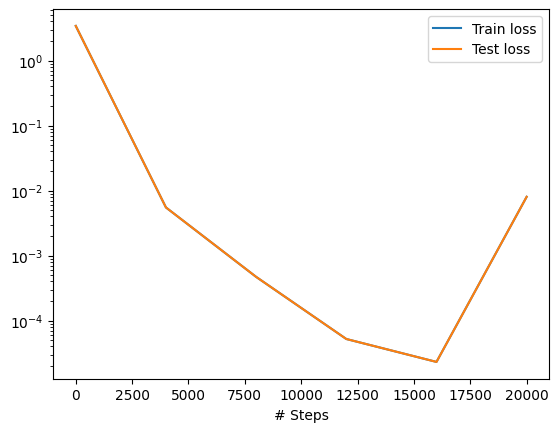

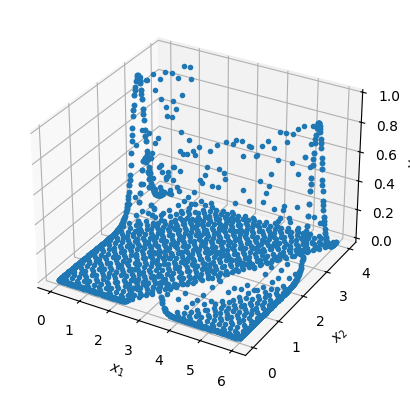

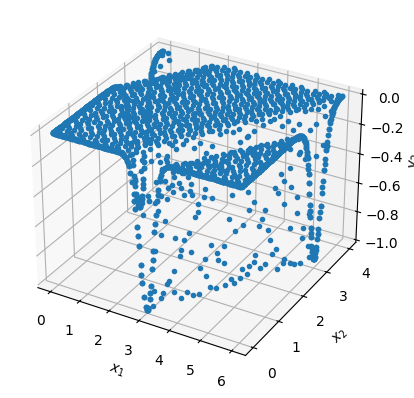

In [44]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# Electromagntic fields plot

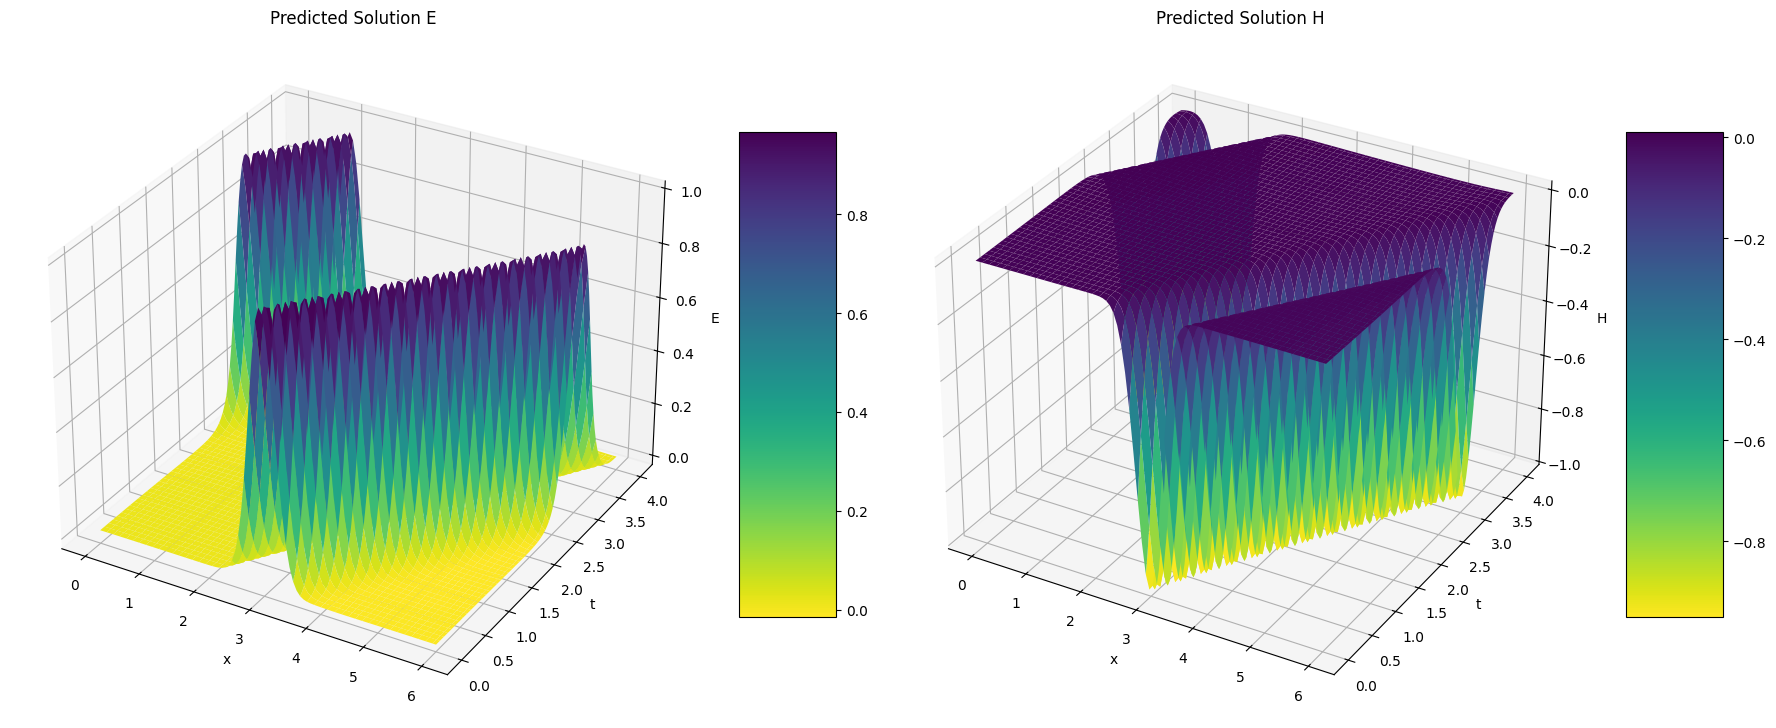

In [43]:
from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(0, 6, 100)
t = np.linspace(0, 4, 100)
X, T = np.meshgrid(x, t)

E_pred, H_pred = model.predict(np.hstack((X.reshape(-1, 1), T.reshape(-1, 1)))).T
E_pred = E_pred.reshape(X.shape)
H_pred = H_pred.reshape(X.shape)

fig = plt.figure(figsize=(18, 10))


# prediction of E
ax3 = fig.add_subplot(121, projection='3d')
E_pred = ax3.plot_surface(X, T, E_pred, cmap='viridis_r', edgecolor='none')
ax3.set_title('Predicted Solution E')
ax3.set_xlabel('x')
ax3.set_ylabel('t')
ax3.set_zlabel('E')
fig.colorbar(E_pred, ax=ax3, shrink=0.5, aspect=5)
# prediction of H
ax4 = fig.add_subplot(122, projection='3d')
H_pred = ax4.plot_surface(X, T, H_pred, cmap='viridis_r', edgecolor='none')
ax4.set_title('Predicted Solution H')
ax4.set_xlabel('x')
ax4.set_ylabel('t')
ax4.set_zlabel('H')
fig.colorbar(H_pred, ax=ax4, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()